__Обучить сиамскую сеть для верификации лиц на датасете LFW.__

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
(train_ds, test_ds), ds_info  = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:80%]', 'train[80%:]']
    )

ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

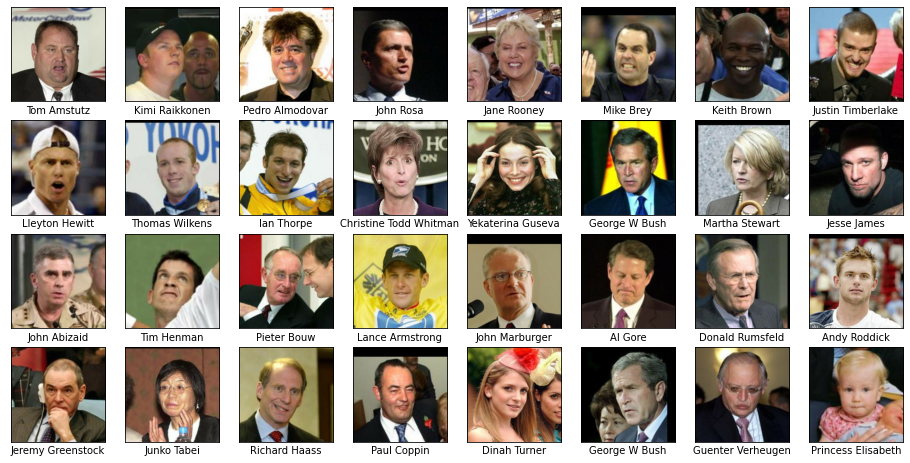

In [3]:
some_samples = [{"image": x[1], "name": x[0]} for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j]["image"])
    ax.set_xlabel(some_samples[j]["name"].numpy().decode('utf-8').replace("_", " "))
    plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
def prepare(label, img):
    img = tf.cast(img, tf.float32)/255.
    return img, label

train_ds = train_ds.map(prepare)

test_ds = test_ds.map(prepare)

In [5]:
EMB_SIZE = 512

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (3, 3)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (3, 3)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (3, 3)),
    tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [6]:
MARGIN = 200.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [7]:
BATCH_SIZE = 16
NUM_EPOCHS = 50

train_ds = train_ds.shuffle(buffer_size=int(13233*0.8))
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [8]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [9]:
for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 1000 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 39852.6640625
[1000] Loss: 0.0
[2000] Loss: 0.0
[3000] Loss: 910.0391845703125
[4000] Loss: 0.0
[5000] Loss: 122.73258209228516
[6000] Loss: 1961.85009765625
[7000] Loss: 0.0
[8000] Loss: 309.2230224609375
[9000] Loss: 61.33994674682617
[10000] Loss: 0.0
[11000] Loss: 6156.24365234375
[12000] Loss: 0.0
[13000] Loss: 0.0
[14000] Loss: 0.0
[15000] Loss: 0.0
[16000] Loss: 1.3889100551605225
[17000] Loss: 128.2501220703125
[18000] Loss: 0.0
[19000] Loss: 0.0
[20000] Loss: 0.0
[21000] Loss: 0.0
[22000] Loss: 0.0
[23000] Loss: 2586.786376953125
[24000] Loss: 626.3585205078125
[25000] Loss: 3.8331446647644043
[26000] Loss: 0.0
[27000] Loss: 0.0
[28000] Loss: 117.69706726074219
[29000] Loss: 500.08837890625
[30000] Loss: 0.0
[31000] Loss: 507.4848327636719
[32000] Loss: 0.0
[33000] Loss: 0.025703324005007744


In [10]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(25, 25))
    for label in labels_for_legend:
        X_embedded_class = X_embedded[targets == label, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

In [11]:
test_x = tf.stack([itm[0] for itm in iter(test_ds)])
test_y = tf.stack([itm[1] for itm in iter(test_ds)])

In [12]:
N = 100

test_embs = model(test_x[:N])

test_embs_2D = TSNE(n_components=2).fit_transform(test_embs[:N])
labels_for_viz = np.array([itm.numpy().decode("utf-8").replace("_", " ") for itm  in test_y[:N]])
labels_for_legend = frozenset([itm.numpy().decode("utf-8").replace("_", " ") for itm  in test_y[:N]])

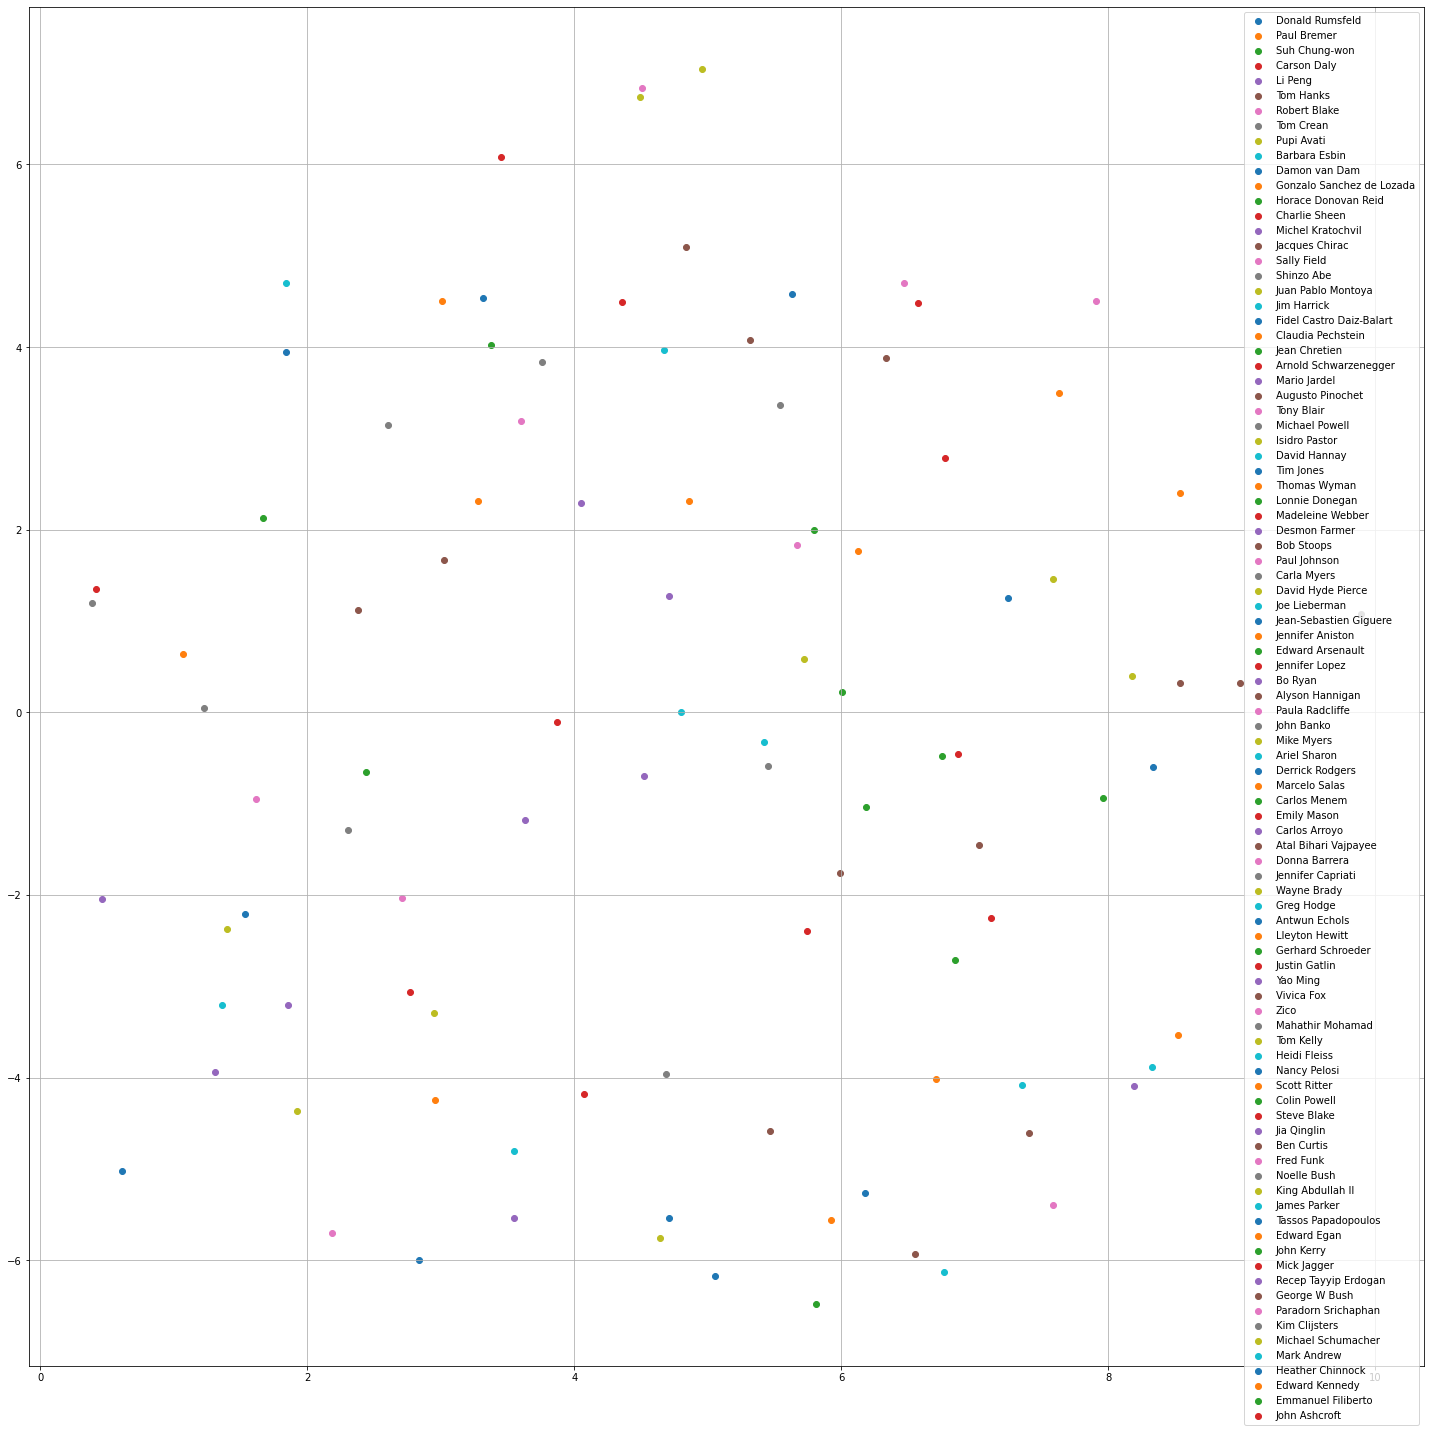

In [13]:
draw_embeddings(test_embs_2D, labels_for_viz, labels_for_legend)

In [14]:
name_for_test = "Arnold Schwarzenegger"
true_x, false_x = {"img": [], "lbl": []}, {"img": [], "lbl": []}
N_images = 10

flag_1, flag_2 = False, False
for i, (img, lbl) in enumerate(zip(test_x, test_y)):
    if lbl.numpy().decode('utf-8').replace("_", " ") == name_for_test:
        if len(true_x["img"]) < N_images:
            true_x["img"].append(img)
            true_x["lbl"].append(lbl)
        else:
            flag_1 = True
    else:
        if len(false_x["img"]) < N_images:
            false_x["img"].append(img)
            false_x["lbl"].append(lbl)
        else:
            flag_2 = True
    
    if flag_1 and flag_2:
        break

test_x_images = tf.convert_to_tensor(true_x["img"] + false_x["img"])
test_x_labels = true_x["lbl"] + false_x["lbl"]

In [15]:
new_embs = model(test_x_images)

In [16]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

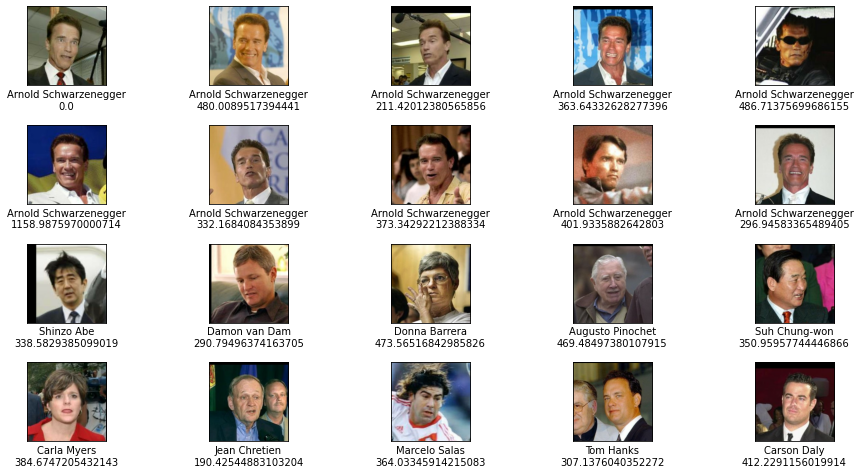

In [30]:
fig = plt.figure(figsize=(16, 8))
etalon = (test_x_images[0], test_x_labels[0], new_embs[0,:])

for i, itm in enumerate(zip(test_x_images, test_x_labels)):
    ax = fig.add_subplot(4, 5, i+1)
    ax.imshow(itm[0])
    ax.set_xlabel(f"{itm[1].numpy().decode('utf-8').replace('_', ' ')}\n{diff(etalon[2], new_embs[i,:])}")
    plt.xticks([]), plt.yticks([])
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()